In [1]:
import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

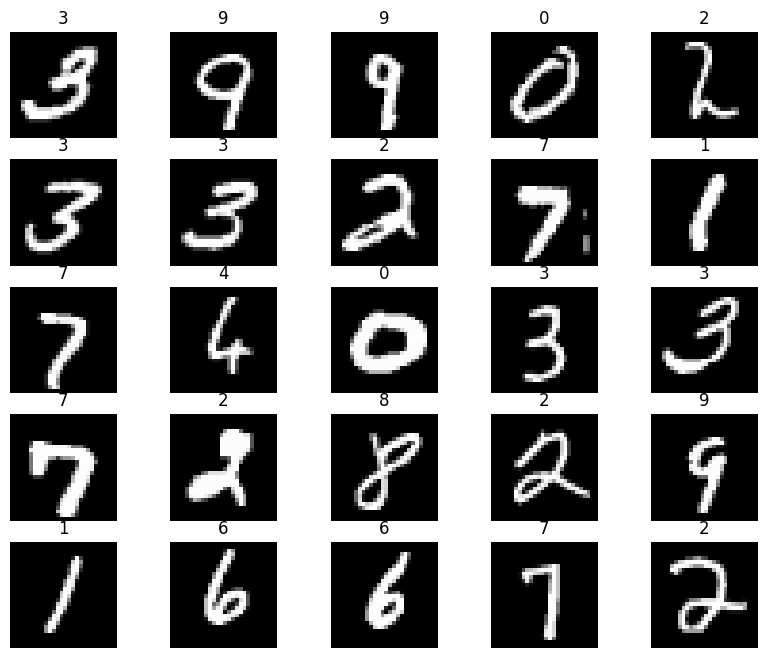

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
loaders = {'train' : torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True,num_workers=1),
                                                  'test'  : torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f120adf44c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f120854ba30>}

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            # nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            # nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        # self.out = nn.Linear(32 * 7 * 7, 10)
        self.out = nn.Sequential(nn.Flatten(),nn.LazyLinear(10))
        
    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        # print(x.shape)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [7]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [27]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [9]:
def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    losses = [0]
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)[0]
            # if i == 0:
            #     print(b_y.shape)
            #     print(output.shape)
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            losses.append(loss.item())
    plt.figure()
    plt.plot(losses)
    plt.title('Training Loss')
    plt.show()

Epoch [1/2], Step [100/600], Loss: 0.1157
Epoch [1/2], Step [200/600], Loss: 0.0835
Epoch [1/2], Step [300/600], Loss: 0.1705
Epoch [1/2], Step [400/600], Loss: 0.1150
Epoch [1/2], Step [500/600], Loss: 0.0940
Epoch [1/2], Step [600/600], Loss: 0.1339
Epoch [2/2], Step [100/600], Loss: 0.0494
Epoch [2/2], Step [200/600], Loss: 0.1119
Epoch [2/2], Step [300/600], Loss: 0.0206
Epoch [2/2], Step [400/600], Loss: 0.1187
Epoch [2/2], Step [500/600], Loss: 0.0183
Epoch [2/2], Step [600/600], Loss: 0.0366


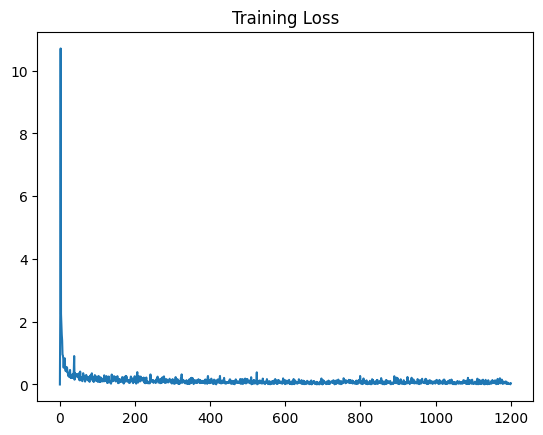

In [28]:
num_epochs = 2     
train(num_epochs, cnn, loaders)

In [11]:
def test(model):
    # Test the model
    model.eval()
    # next(model.parameters()).device
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images, labels = images.to(device), labels.to(device)
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    cols,rows = 5,5
    sample = next(iter(loaders['test']))
    imgs, lbls = sample
    imgs, lbls = imgs.to(device), lbls.to(device)
    test_output, last_layer = model(imgs[:cols * rows])
    test_output = test_output.to('cpu')
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(cols * rows):
        figure.add_subplot(rows, cols, i+1)
        plt.title(pred_y[i])
        plt.axis("off")
        plt.imshow(imgs[i].to('cpu').squeeze(), cmap="gray")
    plt.show()
# test()

Test Accuracy of the model on the 10000 test images: 0.99


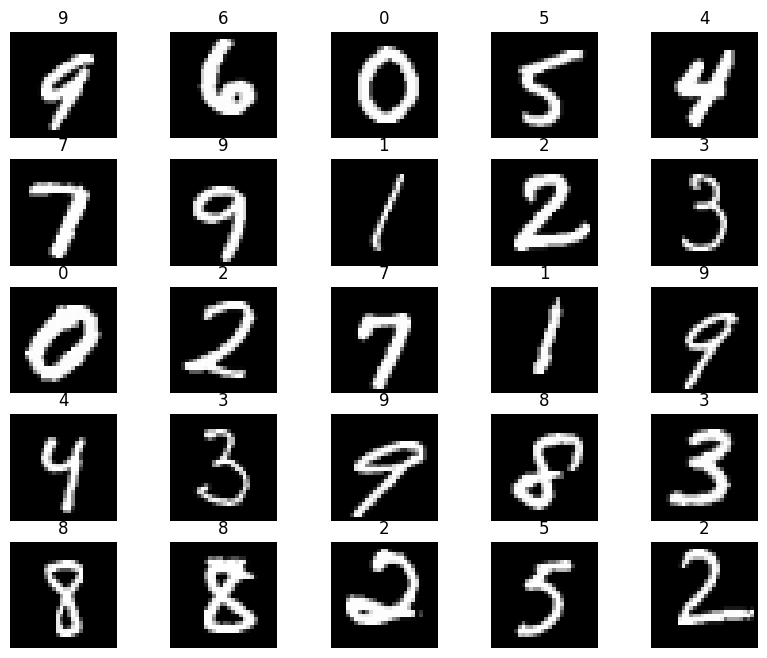

In [29]:
test(cnn)

In [13]:
class FlattenNN(nn.Module):
    def __init__(self,rows,cols):
        super().__init__()        
        self.layer0 = nn.Sequential(nn.Flatten(),
                                nn.Linear(rows*cols, 1024),
                                nn.ReLU())
        self.layer1 = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU())
        self.out = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x) 
        output = self.out(x)
        return output, x    # return x for visualization

flat = FlattenNN(28,28)
print(flat)

FlattenNN(
  (layer0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=256, out_features=10, bias=True)
)


Epoch [1/2], Step [100/600], Loss: 0.3434
Epoch [1/2], Step [200/600], Loss: 0.1914
Epoch [1/2], Step [300/600], Loss: 0.2311
Epoch [1/2], Step [400/600], Loss: 0.1502
Epoch [1/2], Step [500/600], Loss: 0.1181
Epoch [1/2], Step [600/600], Loss: 0.2170
Epoch [2/2], Step [100/600], Loss: 0.0320
Epoch [2/2], Step [200/600], Loss: 0.0848
Epoch [2/2], Step [300/600], Loss: 0.2589
Epoch [2/2], Step [400/600], Loss: 0.0262
Epoch [2/2], Step [500/600], Loss: 0.0915
Epoch [2/2], Step [600/600], Loss: 0.1238


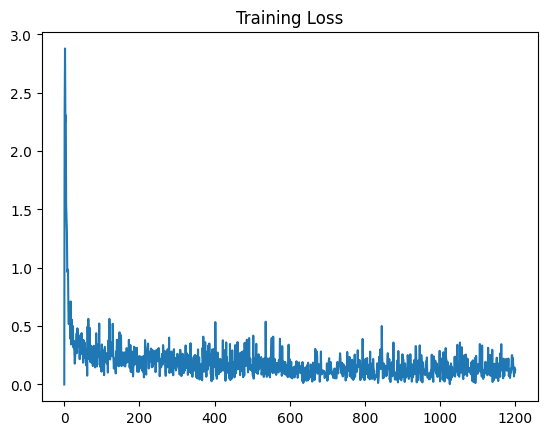

In [14]:
num_epochs = 2
flat = FlattenNN(28,28).to(device)
optimizer = optim.Adam(flat.parameters(), lr = 0.01)   
train(num_epochs, flat, loaders)

Test Accuracy of the model on the 10000 test images: 0.96


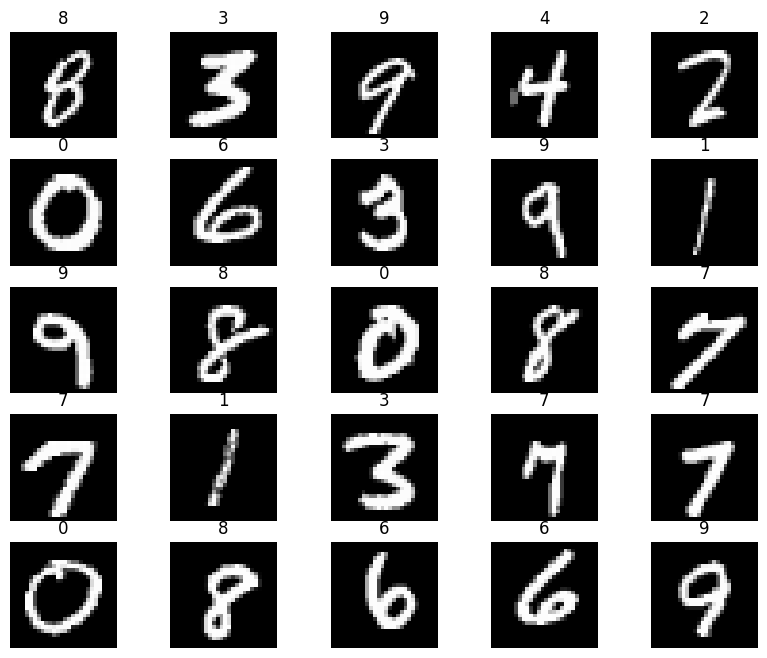

In [15]:
test(flat)

In [16]:
import modules as m

In [17]:
class SNS(nn.Module):
    def __init__(self,rows,cols):
        super().__init__()   
        self.flat = nn.Flatten()
        self.layer0 = nn.Sequential(nn.Flatten(),
                                nn.Linear(rows*cols, 1024))
        self.pre = m.NonSpikingLayer(1024)
        self.conductance = m.NonSpikingConductance(1024,256)
        self.synapse = m.ChemicalSynapse(1024,256)
        self.post = m.NonSpikingLayer(256)
        self.out = nn.Sequential(m.PiecewiseActivation(),
                                 nn.Linear(256, 10))
        
    def forward(self, x):
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.layer0(x)
        # print(x.shape)
        x = self.pre(x)
        # print(x.shape)
        # print(self.post.state_0.unsqueeze(1).shape)
        x = self.conductance(x)
        x = self.synapse(x,self.post.state_0)
        x = self.post(x)
        output = self.out(x)
        return output, x    # return x for visualization

sns = SNS(28,28)
print(sns)

SNS(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
  )
  (pre): NonSpikingLayer()
  (conductance): NonSpikingConductance(
    (activation): PiecewiseActivation()
  )
  (synapse): ChemicalSynapse()
  (post): NonSpikingLayer()
  (out): Sequential(
    (0): PiecewiseActivation()
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [18]:
num_epochs = 2
sns = SNS(28,28).to(device)
optimizer = optim.Adam(sns.parameters(), lr = 0.01)   

Epoch [1/2], Step [100/600], Loss: 0.3994
Epoch [1/2], Step [200/600], Loss: 0.2980
Epoch [1/2], Step [300/600], Loss: 0.3981
Epoch [1/2], Step [400/600], Loss: 0.1032
Epoch [1/2], Step [500/600], Loss: 0.1789
Epoch [1/2], Step [600/600], Loss: 0.2310
Epoch [2/2], Step [100/600], Loss: 0.2668
Epoch [2/2], Step [200/600], Loss: 0.2048
Epoch [2/2], Step [300/600], Loss: 0.2154
Epoch [2/2], Step [400/600], Loss: 0.1603
Epoch [2/2], Step [500/600], Loss: 0.2374
Epoch [2/2], Step [600/600], Loss: 0.1459


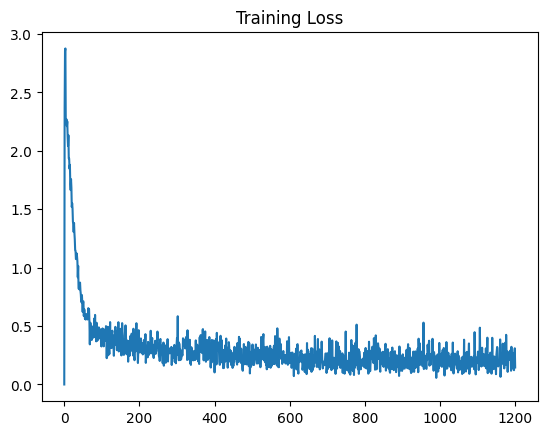

In [19]:
train(num_epochs, sns, loaders)

Test Accuracy of the model on the 10000 test images: 0.98


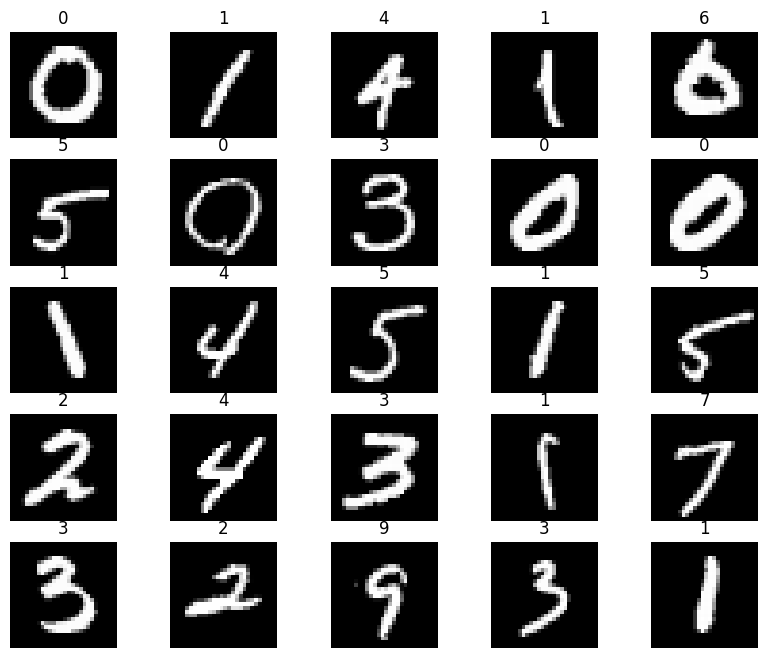

In [20]:
test(sns)

In [21]:
class SNSCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = m.ChemicalConv2D(in_channels=1,              
                out_channels=1,            
                kernel_size=5,              
                stride=1,                   
                padding=2)
        self.layer0 = m.NonSpikingLayer([28,28])     
        self.conv1 = m.ChemicalConv2D(in_channels=1,              
                out_channels=1,            
                kernel_size=5,              
                stride=1,                   
                padding=2)
        self.layer1 = m.NonSpikingLayer([28,28])
        self.out = nn.Sequential(nn.Flatten(),
                                 m.PiecewiseActivation(),
                                 nn.LazyLinear(10))
        
    def forward(self, x):
        x = self.conv0(x, self.layer0.state_0)
        x = self.layer0(x)
        x = self.conv1(x, self.layer1.state_0)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        # print(x.shape)
        x = self.layer1(x)
        output = self.out(x)
        return output, x    # return x for visualization

sns_cnn = SNSCNN().to(device)
print(sns_cnn)

SNSCNN(
  (conv0): ChemicalConv2D(
    (conv_left): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (conv_right): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (act): PiecewiseActivation()
  )
  (layer0): NonSpikingLayer()
  (conv1): ChemicalConv2D(
    (conv_left): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (conv_right): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (act): PiecewiseActivation()
  )
  (layer1): NonSpikingLayer()
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): PiecewiseActivation()
    (2): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [22]:
num_epochs = 2
sns_cnn = SNSCNN().to(device)
optimizer = optim.Adam(sns_cnn.parameters(), lr = 0.01)   

Epoch [1/2], Step [100/600], Loss: 0.1557
Epoch [1/2], Step [200/600], Loss: 0.1713
Epoch [1/2], Step [300/600], Loss: 0.1871
Epoch [1/2], Step [400/600], Loss: 0.0708
Epoch [1/2], Step [500/600], Loss: 0.0323
Epoch [1/2], Step [600/600], Loss: 0.1527
Epoch [2/2], Step [100/600], Loss: 0.0705
Epoch [2/2], Step [200/600], Loss: 0.1005
Epoch [2/2], Step [300/600], Loss: 0.1923
Epoch [2/2], Step [400/600], Loss: 0.2606
Epoch [2/2], Step [500/600], Loss: 0.0817
Epoch [2/2], Step [600/600], Loss: 0.0969


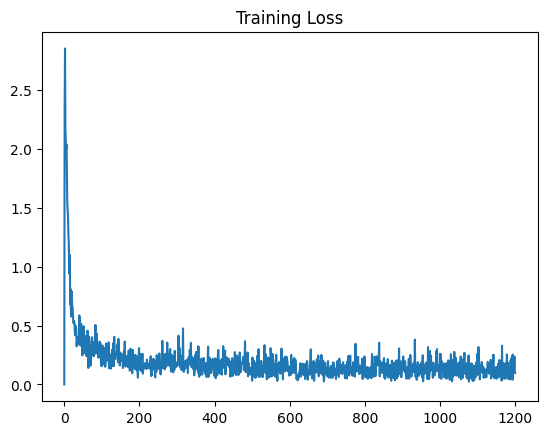

In [23]:
train(num_epochs, sns_cnn, loaders)

Test Accuracy of the model on the 10000 test images: 0.98


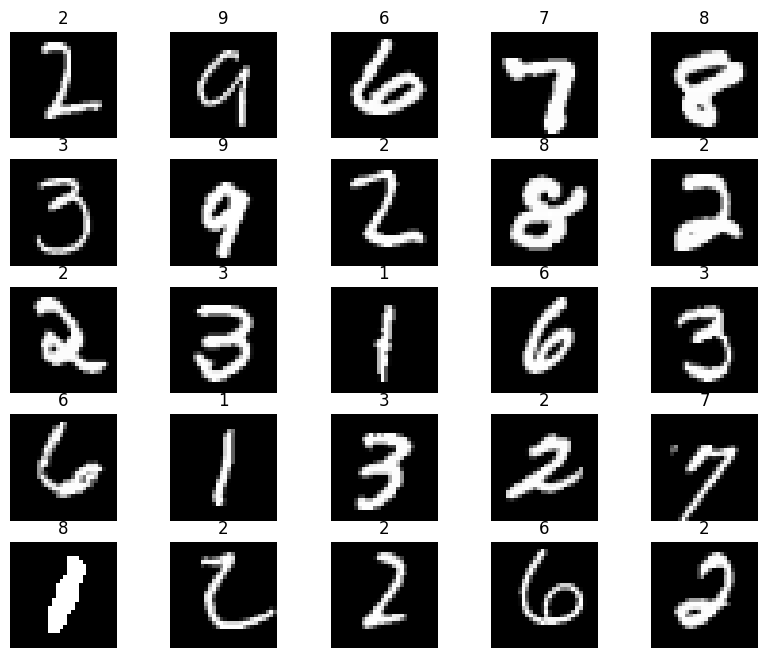

In [24]:
test(sns_cnn)